Requires installation of pandas, matplotlib, and networkx

In [2]:
import pandas as pd

## Co-Citation Counting

I previously gathered citation data from Pubmed that included literature pertaining to histones written in English and published between 1980 and 1990. This data was matched against the open_citations database and the resulting data frame contained 4,508 nodes (dois) and 249,919 edges (direct citations). Using the dois of citing papers and the dois of cited papers, I am examining co-citation within this dataset with the following questions in mind: What does the distribution of co-citation pairs look like and which pair of papers is most highly co-cited? What topics or other features unite the most highly co-cited pair? I also created rudimentary graphs of the co-citation pairs in an attempt to visualize the relationships between cited nodes.

To count the co-citations, I had to organize the data such that for each citing paper, each possible pairwise combination of cited papers was generated and then the frequency of each pairing was counted across the entire data set. To accomplish this, I created two dictionaries, one to create a list of references found within each citing paper, and then another dictionary to generate and count all the pairs found within the list of references. Further details about each dictionary are provided below.

In [3]:
citation_data = pd.read_csv(f'histone_export.csv')

I used two columns of the citation data gathered previously: a column containing citing dois and a column containing cited dois. Each unique citing node is added to a dictionary key (String) and its cited doi is added to the value of this key as an item in a list. Each time a citing doi is found that is already in the dictionary, the cited node is added to the value list. For example, if a paper cites two other papers, the dictionary will look like: {citing_doi: [cited_doi_1, cited_doi_2]}.

In [4]:
dictionary = {}

for i in range(len(citation_data)):
  citing_paper = citation_data['citing'][i]
  if citing_paper in dictionary:
    # save keys (citations) from citing paper
    cited_list = dictionary.get(citing_paper)
    # add the cited paper to the list
    cited_list += [citation_data['cited'][i]]
    # add key : updated citing list back into the dictionary
    dictionary[citing_paper] = cited_list
  else:
    # add new key : value pair
    dictionary[citing_paper] = [citation_data['cited'][i]]

This next block takes the dictionary from the block above and goes through each values list. If the length of the list 
is less than one (meaning the citing paper contained only one references), then this list is discarded. If two or more papers
were cited, the list of values is iterated over and each unique citation pairing is added as a dictionary key. Each time 
this pair occurs, the value of the pair is increased by one. The resulting format is {"cited_doi_1, cited_doi_2" :
number_of_instances}.

In [5]:
count_dict = {}
for i in dictionary:
    # get the list of cited papers
    ref_list = dictionary.get(i)
    if len(ref_list) > 1:
        # find each combination of cited papers
        for j in range(len(ref_list)):
            for k in range(j+1, len(ref_list)):
                # if the given combination isn't in the dictionary, add a new key. Else increase the value by one.
                if str(ref_list[j]) + " " + str(ref_list[k]) not in count_dict:
                    count_dict[str(ref_list[j]) + " " + str(ref_list[k])] = 1
                else:
                    count_dict[str(ref_list[j]) + " " + str(ref_list[k])] += 1

df = pd.DataFrame(list(count_dict.items()), columns=['Pair', 'Count'])
df = df.sort_values('Count')
df.to_csv('result.csv')
df

,Pair,Count
2694384,10.1016/s0074-7696(08)60558-6 10.1007/bf02893563,1
1450284,10.1139/o78-075 10.1016/s0021-9258(17)43980-9,1
1450283,10.1139/o78-075 10.1016/s0021-9258(17)34724-5,1
1450282,10.1139/o78-075 10.1016/s0021-9258(18)32583-3,1
1450281,10.1139/o78-075 10.1016/s0021-9258(18)33780-3,1
...,...,...
47654,10.1016/0092-8674(88)90060-8 10.1038/335251a0,152
33390,10.1146/annurev.bi.51.070182.000513 10.1146/an...,154
84923,10.1016/0092-8674(84)90300-3 10.1016/0092-8674...,200
94271,10.1146/annurev.bi.49.070180.005343 10.1146/an...,202


A note on the above code: the current version treats "doi1 doi2" and "doi2 doi1" as separate pairs, which I would avoid doing in the future. This is an artifact of using a string to sort my dois, as strings can't be sorted. A future version could use a tuple or a list of two items, which could be manipulated so that ["doi2", "doi1"] is changed to ["doi1, doi2"] and then all instances of ["doi1, doi2"] would be counted. The current version likely splits co-citaiton counts between two rows. I generated 2.69 million co-citation pairs, though again, this number may be inflated with duplicates where "doi1 doi2" and "doi2 doi1" are treated as different pairs. 

Additionally, no adjustments were made to account for null values in either the citing or cited columns. I'm unsure to what extent null values are present in this current dataset, but nonetheless future versions should account for that as well.

The plot below shows that 1,000,000 co-citation pairs are cited together fewer than 25 times. The number of pairs decreases as the number of co-citation occurrances increases. The distribution appears to be a power law distribution with a very high number of co-citations appearing together infrequently and a very low number of co-citations appearing together frequently. If we use co-citation as a measure of "relatedness" in the data, this means that only a few nodes have been determined to be closely related by the citing authors. 

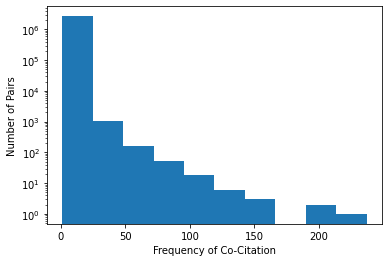

In [6]:
ax = df.plot(kind="hist", logy=True)
ax.set_xlabel('Frequency of Co-Citation')
ax.set_ylabel('Number of Pairs')
ax.get_legend().remove()

I selected a histogram to display this data to show count information on the y-axis. However, as the histogram "bins" frequencies together, some density information is lost. For example, the plot shows that there were 11 pairs co-cited around 100 times (approximately, as it's a bit difficult to tell the range of the bins by sight alone), but the plot does not reflect whether most of these pairs were co-cited 100 times, whether most of them were co-cited 125 times, or whether there was an even distribution of data points. Because of this lack of detail, I would consider using a plot that shows individual data points instead of bins in the future. 

The table below shows the top-ten most highly co-cited pairs in the histone data. The highest co-citation frequency was 237 co-citations, which occurred once with the pairing of "Sequence periodicities in chicken nucleosome core DNA" by Satchwell, Drew, and Travers (1986) https://doi.org/10.1016/0022-2836(86)90452-3 and "DNA bending and its relation to nucleosome positioning" by Drew and Travers (1985) https://doi.org/10.1016/0022-2836(85)90396-1. Both papers are related to the positioning of DNA around a histone, they were published a year apart from each other, and two authors are shared between them. Given the overlap in subject matter and authorship, I'm unsurprised that these two items are so highly co-cited, especially if Drew and/or Travers went on to cite these two papers in their future work.

This table doesn't show the entire co-citation pair as some characters get cut off (another artifact of using strings, this can be avoided by indexing a tuple or list), but at least two of the most-commonly cited pairs contains at least one annual review paper, including the second most-commonly cited pair. The top-ten most highly co-cited pairs each occurs more than 100 times, but the difference between the most highly co-cited pair and the 10th most highly co-cited is approximately the same as the difference between the 10th most highly co-cited and the least frequently co-cited, even though there are millions of co-citations separating the latter.

In [7]:
df.tail(10)

,Pair,Count
23753,10.1002/j.1460-2075.1986.tb04240.x 10.1016/009...,122
47632,10.1016/0092-8674(90)90599-a 10.1016/0092-8674...,129
47804,10.1016/0092-8674(89)90687-9 10.1016/0092-8674...,132
47738,10.1038/346760a0 10.1016/0092-8674(89)90936-7,132
27694,10.1126/science.7433974 10.1093/nar/8.17.3757,145
47654,10.1016/0092-8674(88)90060-8 10.1038/335251a0,152
33390,10.1146/annurev.bi.51.070182.000513 10.1146/an...,154
84923,10.1016/0092-8674(84)90300-3 10.1016/0092-8674...,200
94271,10.1146/annurev.bi.49.070180.005343 10.1146/an...,202
23091,10.1016/0022-2836(86)90452-3 10.1016/0022-2836...,237


## Graphing

I experimented with both Networkx and Pyvis to visualize the co-citation graph, but I could only get Networkx to complete as Pyvis ran for four hours before I stopped the program. (In retrospect, I should have tried to generate a smaller graph in Pyvis first before attempting it on my entire dataset.) The second of the code blocks below should generate a graph that includes each co-citation that occurs once or more, or every item in my data frame. The third code block does the same but for pairs that occur three times or more. 

### One or More Occurrences

Note: The following code takes approximately 25 minutes to run on my Macbook with M1 chip. It may take some time to finish completing.

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

def graph_co_citation(int):

    G = nx.Graph()

    keys = count_dict.keys()
    edge_list = [('Item 1', 'Item 2')]
    # for each co-citation pair
    for j in keys:
    # if the number of co-citation occurances is greater or equal to (int)
        if count_dict.get(j) >= int:
            edge = j.split()
            # get both items in the pair and add to a list of tuples
            edge_list.append((edge[0], edge[1]))
    # delete the header
    del edge_list[0]

    # each item in the list of edges is a node
    # does this add multiple nodes of the same doi? Investigate
    for i in edge_list:
        G.add_node(edge_list[0])
        G.add_node(edge_list[1])

    G.add_edges_from(edge_list)

    nx.draw(G)
    plt.draw()

KeyboardInterrupt: 

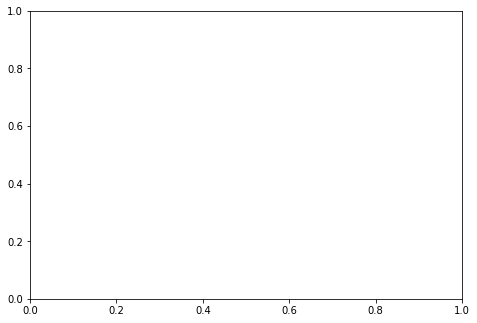

In [9]:
graph_co_citation(1)

### Three or More Occurrences

Note: This took less than two minutes to run on my Macbook with M1 chip. Runtimes may vary, however. 

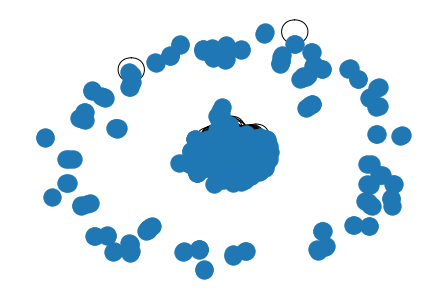

In [10]:
graph_co_citation(3)

Some critiques on the graphs: The graphs above provide very little information and it's difficult to tell what is being displayed. The nodes aren't clearly defined or spaced well so it's difficult to tell whether some circles are overlapping nodes or just a single node. The nodes aren't labeled, though there might be a way to generate labels that I'm missing. To its benefit, the Networkx graphs were generated quickly compared to Pyvis, the other package I tried to use. However, speed is useless if the resulting graph is illegible. Making these graphs was useful as an exercise in getting the data into a format that could be read by graphing packages, but in the future I would look at other tools that could provide more meaningful graphs, with separation between nodes and clear edges. 

## Conclusions

This was an exercise in generating all the co-citation pairs in a relatively small citation dataset and counting the frequency of those pairs. One issue I ran into was efficiency problems as the size of the data increased. For example, I started with a dataset of 249,919 edges that I got by appending rows to a pandas dataframe. This approach did not scale well, as I ended up with 2.69 million (hopefully) mostly unique citation pairings, and appending to a dataframe became an incredibly slow process. 

After I switched to a more efficient data storage system, I was able to determine that the co-citation data had a power law distribution where highly co-cited pairs were infrequent while less-commonly co-cited pairs were common. Additionally, I was able to determine the most highly co-cited papers had a similar subject matter and two of the three co-authors were authors on both papers. Due to the high co-citation rate, it appears that either the research community determined these two papers to be highly related, the authors freqently self-cited as time went on, or perhaps a combination of both. 

Some things I would change moving forward involve being more careful with my data wrangling and thinking more critically about my use of data structures. I realized that my solution treated "doi1 doi2" and "doi2 doi1" pairs as separate pairings, but I couldn't figure out a way to reconcile this difference while using a single string to store this data. A more flexible alternative, and one that would have solved this problem, would be not using a string at all, as I discussed previously. 

I'm also interested in looking into different graphing packages, as I'm disappointed in the graphs I generated here. It was a good first step, but I'm also looking forward to seeing what other tools are capable of. 